In [21]:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import pickle
    %matplotlib inline
    # from sklearn.preprocessing import MinMaxScaler
    # from skimage.transform import resize
    import pandas as pd
    from tqdm.notebook import tqdm

    import tensorflow as tf
    import tensorflow.keras 
    # import keras
    # from tensorflow.keras.layers import *
    from tensorflow.keras import layers
    from tensorflow.keras import *
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.preprocessing.image import *
    from tensorflow.keras.callbacks import ModelCheckpoint
    # from keras.callbacks import TensorBoard
    import matplotlib.pyplot as plt

    # from google.colab import drive
    # drive.mount("/content/gdrive")

In [2]:
# os.chdir("gdrive/MyDrive/Colab")
# _DATA_DIR = "data"

In [3]:
# Viewing side by side with cropped version
def plot_input_output(shape, u, v, p, index = np.random.randint(0,981)):
    plt.figure(figsize=(15,55))
    # index = np.random.randint(0,dataX.shape[0])
    # fig, ax = plt.subplots(ncols=4, nrows=1)
    plt.subplot(1,4,1)
    plt.title("geometry: "+str(index))
    img_shape = shape[index,:,:,0]
    print(img_shape.shape)
    shape_im = plt.imshow(img_shape, cmap="gray")
    plt.colorbar(shape_im,fraction=0.08, pad=0.05)

    plt.subplot(1,4,2)
    plt.title("u")
    img_u = u[index,:,:,0]
    u_im = plt.imshow(img_u, cmap="jet", vmin=-1, vmax=1)
    plt.colorbar(u_im,fraction=0.08, pad=0.05)

    plt.subplot(1,4,3)
    plt.title("v")
    img_v = v[index,:,:,0]
    v_im = plt.imshow(img_v, cmap="jet", vmin=-1, vmax=1)
    plt.colorbar(v_im,fraction=0.08, pad=0.05)

    plt.subplot(1,4,4)
    plt.title("p")
    img_p = p[index,:,:,0]
    p_im = plt.imshow(img_p, cmap="jet", vmin=-1, vmax=1)
    plt.colorbar(p_im,fraction=0.08, pad=0.05)

    return plt

In [4]:
def reshape2last(f):
    reshaped = f.reshape((f.shape[0],f.shape[1],f.shape[2],1))
    # normalized = 1.0*reshaped/np.max(reshaped)
    normalized = reshaped
    return normalized

def load_data(data_dir):
    with open(os.path.join(data_dir,"shape.npy"), 'rb') as f:
        shape_orig = np.load(f)
    with open(os.path.join(data_dir,"u.npy"), 'rb') as f:
        u_orig = np.load(f)
    with open(os.path.join(data_dir,"v.npy"), 'rb') as f:
        v_orig = np.load(f)
    with open(os.path.join(data_dir,"p.npy"), 'rb') as f:
        p_orig = np.load(f)

    #Also, rescaling
    shape = reshape2last(shape_orig)
    u = reshape2last(u_orig)/2
    v = reshape2last(v_orig)/6
    p = reshape2last(p_orig)/2 

    print(shape.shape, u.shape, v.shape, p.shape)
    return shape, u, v, p

In [9]:
def encoder_block(prev_layer, filter_count, name, batch_norm = True, kernel_size = (3,3)):
    x = layers.Conv2D(filter_count,kernel_size=kernel_size, strides=(2,2), padding="same", name=name)(prev_layer)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    return x

def decoder_block(prev_layer, skip_layer, filter_count, name, batch_norm = True, dropout = True, kernel_size = (3,3)):
    x = layers.Conv2DTranspose(filter_count, kernel_size=kernel_size, strides=(2,2), padding="same", name=name)(prev_layer)
    if batch_norm:
        x = layers.BatchNormalization()(x)

    if dropout:
        x = layers.Dropout(0.5)(x)

    x = layers.Activation("relu")(x)

    x = layers.concatenate([x,skip_layer])

    return x

def generator_model(img_size=(128,64,1), output_branch=1):
    input = tf.keras.Input(shape=img_size)
    # output_layers = []
    # branch_names = ["u", "v", "p", "w"]

    # Encoder
    e0 = layers.Conv2D(filters=8, kernel_size=(3,3), strides=(2,1),padding="same", name="e0")(input) #output: (64x64x8)
    e1 = encoder_block(e0, 16, name="e1", batch_norm=False) #output: (32x32x64)
    e2 = encoder_block(e1, 64, name="e2")   #output: (16x16x128)
    e3 = encoder_block(e2, 128, name="e3")   #output: (8x8x256)
    e4 = encoder_block(e3, 512, name="e4")   #output: (4x4x512)
    e5 = encoder_block(e4, 512, name="e5")   #output: (2x2x512)

    # bottleneck
    b = layers.Conv2D(512,kernel_size=3, strides=(2,2),padding="same",activation="relu", name="bottleneck")(e5)   #output: (1x1x512)

    # Decoder
    for branch_index in range(output_branch):
        print("[INFO] Branch Index : "+str(branch_index))
    d0 = decoder_block(b, e5, 512, name="d0")    #output: (2x2x512)
    d1 = decoder_block(d0, e4, 512, name="d1")   #output: (4x4x512)
    d2 = decoder_block(d1, e3, 128, name="d2")  #output: (8x8x128)
    d3 = decoder_block(d2, e2, 64, name="d3", dropout=False)   #output: (16x16x64)
    d4 = decoder_block(d3, e1, 16, name="d4", dropout=False)   #output: (32x32x16)
    d5 = decoder_block(d4, e0, 8, name="d5", dropout=False)   #output: (32x32x16)

    output = layers.Conv2DTranspose(3, kernel_size=(3,3), strides=(2,1), activation="tanh", padding="same")(d5)
    # output_layers.append(output_image)

    model = Model(input,output)

    return model

In [18]:
def discriminator_model(img_size=(128,64,3)):
    input_shape = tf.keras.Input(shape=(128,64,1))
    input_generated = tf.keras.Input(shape=img_size)

    input = layers.concatenate([input_shape,input_generated]) #output: 128x64x4

    x = layers.Conv2D(16,(3,3), strides=(2,1), padding="same")(input) #output : 64,64,16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)


    x = layers.Conv2D(64,(3,3),strides=(2,2),padding="same")(x) #output : 32x32x64
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128,(3,3),strides=(2,2),padding="same")(x) #output : 16x16x128
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256,(3,3),strides=(1,1),padding="same")(x) #output : 16x16x256
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    output = layers.Conv2D(1,(3,3),strides=(1,1),padding="same",activation="sigmoid")(x) #output : 16x16x1

    disc_model = Model([input_shape,input_generated],output)
    return disc_model

In [22]:
tf.keras.backend.clear_session()
input_shape = (128,64,1)
generator = generator_model((128,64,1), output_branch = 1)
plot_model(generator,"pix2flows_generative_model.png",show_shapes=True, show_layer_names=True)
generator.summary()

[INFO] Branch Index : 0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
e0 (Conv2D)                     (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
e1 (Conv2D)                     (None, 32, 32, 16)   1168        e0[0][0]                         
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 16)   0           e1[0][0]                         
______________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 64, 4)   0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   592         concatenate_6[0][0]        

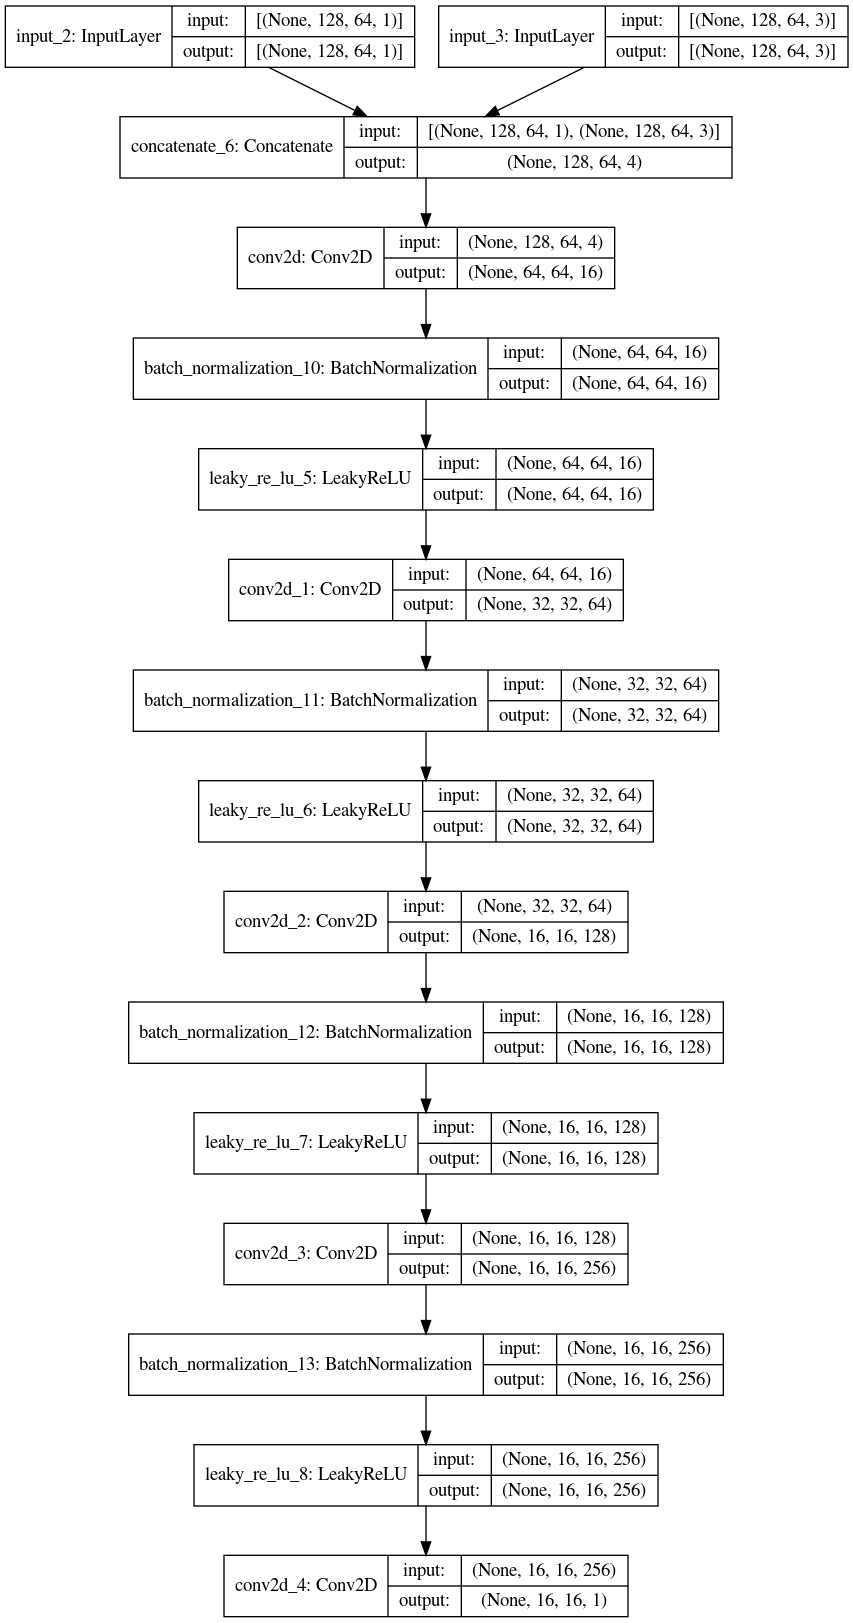

In [23]:
discriminator = discriminator_model()
discriminator.summary()
plot_model(discriminator,"pix2flows_discriminator_model.png",show_shapes=True)

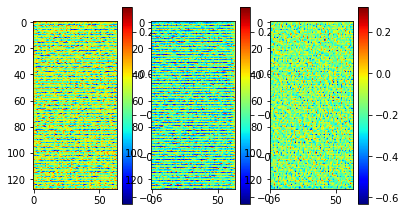

In [43]:
random_input = np.random.rand(1,128,64,1)
# plt.imshow(random_input[0,:,:,0],vmin=0,vmax=1,cmap='RdBu_r')
gen_output = generator(random_input)

f = 0.1
p = 0.05

plt.subplot(1, 3, 1)
im1 = plt.imshow(gen_output[0,:,:,0],cmap='jet')
plt.colorbar(im1,fraction=f, pad=p)

plt.subplot(1, 3, 2)
im2 = plt.imshow(gen_output[0,:,:,1],cmap='jet')
plt.colorbar(im1,fraction=f, pad=p)

plt.subplot(1, 3, 3)
im3 = plt.imshow(gen_output[0,:,:,2],cmap='jet')
plt.colorbar(im1,fraction=f, pad=p)

plt.show()

In [44]:
def navier_loss_2d(y_pred, rho=10, nu=0.0001):
    u,v,p = tf.split(y_pred, 3, axis=3)

    #First order derivative
    du_dx, du_dy = tf.image.image_gradients(u)
    dv_dx, dv_dy = tf.image.image_gradients(v)
    dp_dx, dp_dy = tf.image.image_gradients(p)

    #Second order derivatives
    du_dx2, du_dydx = tf.image.image_gradients(du_dx)
    du_dxdy, du_dy2 = tf.image.image_gradients(du_dy)

    dv_dx2, dv_dydx = tf.image.image_gradients(dv_dx)
    dv_dxdy, dv_dy2 = tf.image.image_gradients(dv_dy)

    er1_tensor = tf.math.multiply(u, du_dx) + tf.math.multiply(v, du_dy) + 1.0*dp_dx/rho - nu*(du_dx2 + du_dy2)
    er2_tensor = tf.math.multiply(u, dv_dx) + tf.math.multiply(v, dv_dy) + 1.0*dp_dy/rho - nu*(dv_dx2 + dv_dy2)

    er1 = tf.reduce_mean(er1_tensor)
    er2 = tf.reduce_mean(er2_tensor)

    momentum_loss = er1*er1 + er2*er2
    conti_loss = tf.reduce_mean((du_dx+dv_dy)*(du_dx+dv_dy)) 

    return  momentum_loss + conti_loss

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(y_true, y_pred, disc_generated_output):
    LAMDA = 100
    GAMMA = 100
    nv_loss = navier_loss_2d(y_pred)
    mae_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))

    gen_loss = mae_loss + GAMMA*nv_loss

    fake_output_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    total_gen_loss = fake_output_loss + LAMDA*gen_loss

    return total_gen_loss,fake_output_loss,mae_loss,nv_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [45]:
import datetime
run_name = "run4"

log_dir="logs/pix2flows/"+run_name+ "fit/"
summary_writer = tf.summary.create_file_writer(
  log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
checkpoint_dir = 'checkpoints/pix2flows/'+run_name

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
def generate_images(model, test_input, tar, epoch="custom", save=True):

    test_input_reshaped = test_input.reshape((1,test_input.shape[0],test_input.shape[1],test_input.shape[2]))

    prediction = model(test_input_reshaped, training=True)
    plt.figure(figsize=(15, 15))

    u_true,v_true,p_true = tf.split(tar, 3, axis=2)
    u_pred,v_pred,p_pred = tf.split(prediction[0], 3, axis=2)

    # print("u_true: "+str(u_true.shape))
    # print("u_pred: "+str(u_pred.shape))

    display_list = [u_true[:,:,0], v_true[:,:,0], p_true[:,:,0], u_pred[:,:,0], v_pred[:,:,0], p_pred[:,:,0]]
    title = ["u_true", "v_true", "p_true", "u_pred", "v_pred", "p_pred"]

    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i],vmin=-1,vmax=1,cmap="jet")
        plt.colorbar()
        plt.axis('off')

    if(save):
        plt.savefig(log_dir+"image_examples/"+str(epoch)+".png")

    plt.show()

In [47]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, fake_output_loss, mae_loss, nv_loss = generator_loss(target, gen_output, disc_generated_output)
        disc_loss, real_disc_loss, fake_disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('fake_output_loss', fake_output_loss, step=epoch)
        tf.summary.scalar('nv_loss', nv_loss, step=epoch)
        tf.summary.scalar('mae_loss', mae_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
        tf.summary.scalar('real_disc_loss', real_disc_loss, step=epoch)
        tf.summary.scalar('fake_disc_loss', fake_disc_loss, step=epoch)

    return gen_total_loss,fake_output_loss,mae_loss,nv_loss,disc_loss, real_disc_loss, fake_disc_loss

In [50]:
import time
from IPython.display import clear_output 
from tqdm import tqdm_notebook

def fit(input_images, epochs, true_outputs):
    random_index = np.random.randint(0,input_images.shape[0])
    # gen_total_loss,fake_loss,mae_loss,nv_loss,disc_loss, real_disc_loss fake_disc_loss = [0]*7

    try:
        os.makedirs(log_dir+"image_examples")
    except:
        print("Example Image directory already exists")

    for epoch in range(epochs):
        start = time.time()

        clear_output(wait=True)

        generate_images(generator, input_images[random_index,:,:,:], true_outputs[random_index,:,:,:],epoch)

        if(epoch!=0):
            print("...........................................................")
            print("gen_total_loss : " + str(gen_total_loss.numpy()))
            print("fake_gen_loss : "+str(fake_loss.numpy())+"   |   mae_loss : "+str(mae_loss.numpy())+"    |   nv_loss : "+str(nv_loss.numpy()))
            print("disc_loss : "+str(disc_loss.numpy())+"   |   real_disc_loss: "+real_disc_loss.numpy()+"   |   fake_disc_loss: "+fake_disc_loss.numpy())
            print("...........................................................")

        print("Epoch: ", epoch)

        # Train
        for n in tqdm_notebook(range(input_images.shape[0])):
            input_image = input_images[n].reshape(1,input_images[n].shape[0],input_images[n].shape[1],input_images[n].shape[2])
            target = true_outputs[n].reshape(1,true_outputs[n].shape[0],true_outputs[n].shape[1],true_outputs[n].shape[2])

            print('.', end='')
            
            if (n+1) % 100 == 0:
                print()
            
            gen_total_loss,fake_loss,mae_loss,nv_loss,disc_loss, real_disc_loss, fake_disc_loss = train_step(input_image, target, epoch)
            print()

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                    time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)

In [51]:
# # # Free up RAM in case the model definition cells were run multiple times
# # keras.backend.clear_session()

# shape, u, v, p = load_data(_DATA_DIR)
# y = np.concatenate((u,v,p),axis=3)
# #input size
# img_size = shape.shape[1:] #(shape.shape[1],shape.shape[2],1)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [53]:
# os.listdir(checkpoint_dir)
checkpoint_dir = "checkpoint_run3_180"
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# random_index = np.random.randint(0,shape.shape[0])
# generate_images(generator, shape[random_index,:,:,:], y[random_index,:,:,:],save=False,)

In [61]:
def custom_prediction(model, test_input, save=True):

    test_input_reshaped = test_input.reshape((1,test_input.shape[0],test_input.shape[1],test_input.shape[2]))

    prediction = model(test_input_reshaped, training=True)
    # plt.figure(figsize=(10,12))

    u_pred,v_pred,p_pred = tf.split(prediction[0], 3, axis=2)

    # print("u_true: "+str(u_true.shape))
    # print("u_pred: "+str(u_pred.shape))

    display_list = [u_pred[:,:,0], v_pred[:,:,0], p_pred[:,:,0]]
    title = ["u_pred", "v_pred", "p_pred"]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i],vmin=-1,vmax=1,cmap="jet")
#         plt.colorbar()
        plt.axis('off')

    if(save):
        plt.savefig("custom.png")

    plt.show()

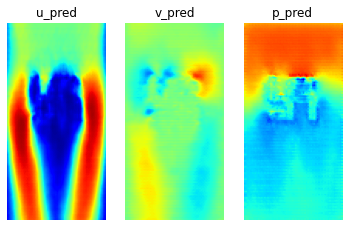

In [62]:
input_file = np.load("input.npy")
custom_prediction(generator,input_file,True)

In [ ]:
fit(shape,200,y)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
input_file = np.load("input (3).npy")
input_file = input_file.reshape((1,128,64,1))
print(input_file.shape)
input_pred = model.predict(input_file)
print(input_pred.shape)
input_pred_u = input_pred[:,:,:,0].reshape((1,128,64,1))
input_pred_v = input_pred[:,:,:,1].reshape((1,128,64,1))
input_pred_p = input_pred[:,:,:,2].reshape((1,128,64,1))

In [ ]:
plot_input_output(input_file, input_pred_u, input_pred_v, input_pred_p, index=0)

In [ ]:
tf.__version__

1. DataGenerator
2. Flip 
3. Model Training
4. logging

In [ ]:
model.save("checkpoints/best_model_4_epoch100")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/best_model_4/ 

In [ ]:
plot_input_output(shape,u,v,p, index=452)
plot_input_output(shape,u_pred,v_pred,p_pred, index=452)

In [ ]:
def draw_subplot(f, id, index, cmap="jet", span=0):
  
  subplot_names = ["geometry: "+str(index), "u_true", "v_true", "p_true",
                   "geometry: "+str(index), "u_pred", "v_pred", "p_pred",
                   "geometry: "+str(index), "u_error", "v_error", "p_error"]

  plt.subplot(3,4,id+1)
  plt.title(subplot_names[id])
  img_shape = f[index,:,:,0]
  # print(img_shape.shape)
  if (span!=0):
    f_im = plt.imshow(img_shape, cmap=cmap, vmin=-span, vmax=span)
  else:
    f_im = plt.imshow(img_shape, cmap=cmap)

  plt.colorbar(f_im,fraction=0.08, pad=0.05)
  


def plot_save(shape, u, v, p, u_pred, v_pred, p_pred):

  _save_dir = "result_images"
  
  plt.figure(figsize=(15,20))
  plt.subplots_adjust(wspace=0.3, hspace=0.2)
  plt.axis("off")
  index=np.random.randint(0,981)

  draw_subplot(shape,0,index,cmap="Greys")
  
  draw_subplot(u,1,index,span=1)
  draw_subplot(v,2,index,span=1)
  draw_subplot(p,3,index, span=1)

  draw_subplot(shape,4,index,cmap="Greys")

  draw_subplot(u_pred,5,index, span=1)
  draw_subplot(v_pred,6,index, span=1)
  draw_subplot(p_pred,7,index, span=1)


  draw_subplot(shape,8,index,cmap="Greys")

  draw_subplot(u_pred-u,9,index,cmap="coolwarm", span=0.2)
  draw_subplot(v_pred-v,10,index,cmap="coolwarm", span=0.2)
  draw_subplot(p_pred-p,11,index,cmap="coolwarm", span=0.2)

  plt.savefig(os.path.join(_save_dir,str(index)+".png"))

In [ ]:
plot_save(shape, u, v, p, u_pred, v_pred, p_pred)

In [ ]:
for i in tqdm(range(100)):
  plot_save(shape, u, v, p, u_pred, v_pred, p_pred)